<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

# Artificial Intelligence in Finance

## Machine Learning

Dr Yves J Hilpisch | The AI Machine

http://aimachine.io | http://twitter.com/dyjh

## Learning

<blockquote>"A computer program is said to learn from experience 𝐸 with respect to some class of tasks 𝑇 and performance measure 𝑃, if its performance at tasks in 𝑇, as measured by 𝑃, improves with experience 𝐸." — Mitchell (1997)</blockquote>


## Data

In [1]:
import numpy as np
import pandas as pd
from pylab import plt, mpl
np.random.seed(100)
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

In [2]:
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

In [3]:
raw = pd.read_csv(url, index_col=0, parse_dates=True)['EUR=']

In [4]:
raw.head()

Date
2010-01-01    1.4323
2010-01-04    1.4411
2010-01-05    1.4368
2010-01-06    1.4412
2010-01-07    1.4318
Name: EUR=, dtype: float64

In [5]:
raw.tail()

Date
2019-12-26    1.1096
2019-12-27    1.1175
2019-12-30    1.1197
2019-12-31    1.1210
2020-01-01    1.1210
Name: EUR=, dtype: float64

In [6]:
l = raw.resample('1M').last()

In [7]:
l.tail()

Date
2019-09-30    1.0898
2019-10-31    1.1150
2019-11-30    1.1015
2019-12-31    1.1210
2020-01-31    1.1210
Freq: M, Name: EUR=, dtype: float64

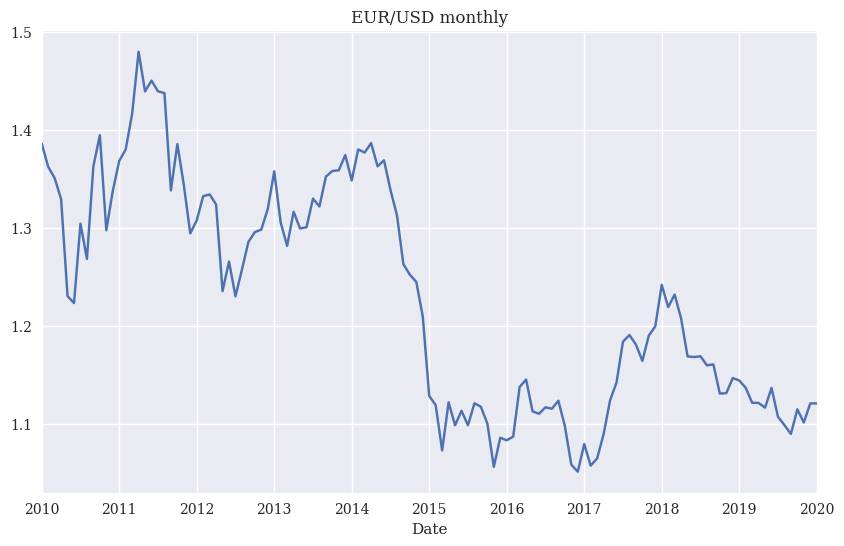

In [8]:
l.plot(figsize=(10, 6), title='EUR/USD monthly');

In [9]:
l = l.values
l -= l.mean()

In [10]:
f = np.linspace(-2, 2, len(l))

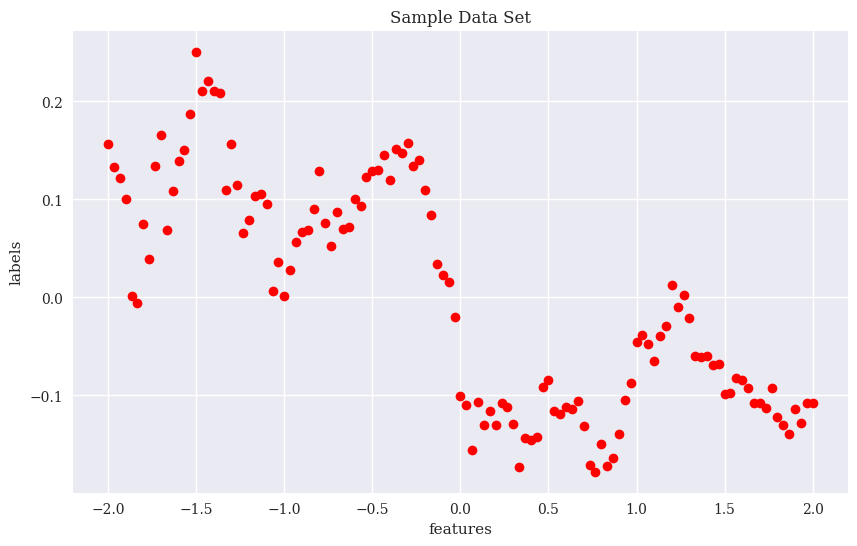

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'ro')
plt.title('Sample Data Set')
plt.xlabel('features')
plt.ylabel('labels');

## Success

In [12]:
def MSE(l, p):
    return np.mean((l - p) ** 2)

In [13]:
reg = np.polyfit(f, l, deg=5)
reg

array([-0.01910626, -0.0147182 ,  0.10990388,  0.06007211, -0.20833598,
       -0.03275423])

In [14]:
p = np.polyval(reg, f)

In [15]:
MSE(l, p)

0.0034166422957371025

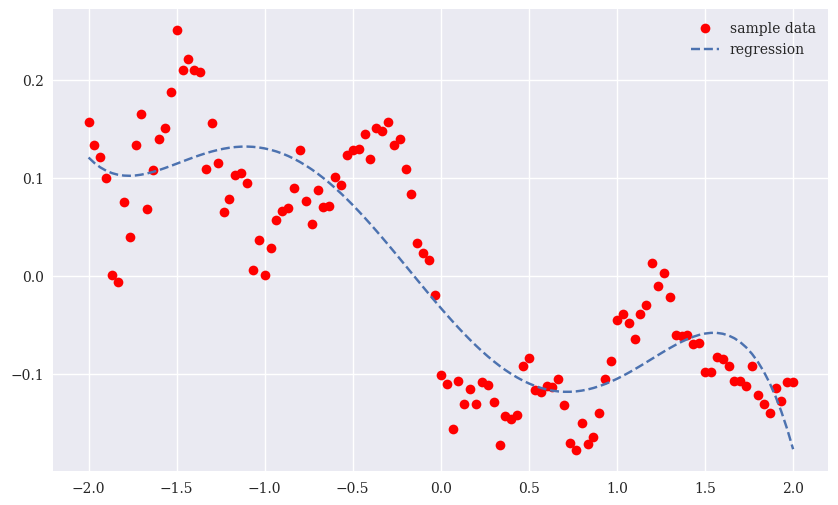

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'ro', label='sample data')
plt.plot(f, p, '--', label='regression')
plt.legend();

In [17]:
%%time
for i in range(10, len(f) + 1, 20):
    reg = np.polyfit(f[:i], l[:i], deg=3)
    p = np.polyval(reg, f)
    mse = MSE(l, p)
    print(f'{i:3d} | MSE={mse}')

 10 | MSE=248628.1068156043
 30 | MSE=731.9382249304597
 50 | MSE=12.236088505004368
 70 | MSE=0.7410590619743285
 90 | MSE=0.005743061730409317
110 | MSE=0.006492800939555572
CPU times: user 643 µs, sys: 323 µs, total: 966 µs
Wall time: 879 µs


In [18]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '6'

In [19]:
import tensorflow as tf
from tensorflow import keras 
tf.random.set_seed(100)

In [20]:
from keras.layers import Dense
from keras.models import Sequential

In [21]:
model = Sequential()  
model.add(Dense(256, activation='relu', input_dim=1))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               512       
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [23]:
%time hist = model.fit(f, l, epochs=1500, verbose=False)

CPU times: user 3.08 s, sys: 436 ms, total: 3.52 s
Wall time: 2.55 s


In [24]:
p = model.predict(f).flatten()

4/4 [==============================] - 0s 598us/step


In [25]:
MSE(l, p)

0.002173810715593439

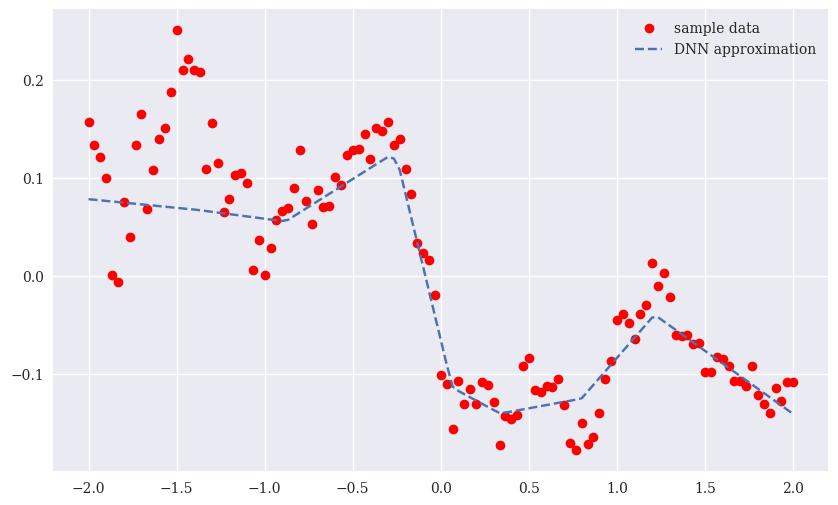

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'ro', label='sample data')
plt.plot(f, p, '--', label='DNN approximation')
plt.legend();

In [27]:
import pandas as pd

In [28]:
res = pd.DataFrame(hist.history)

In [29]:
res.tail()

,loss
1495,0.001758
1496,0.001902
1497,0.001850
1498,0.001926
1499,0.002187


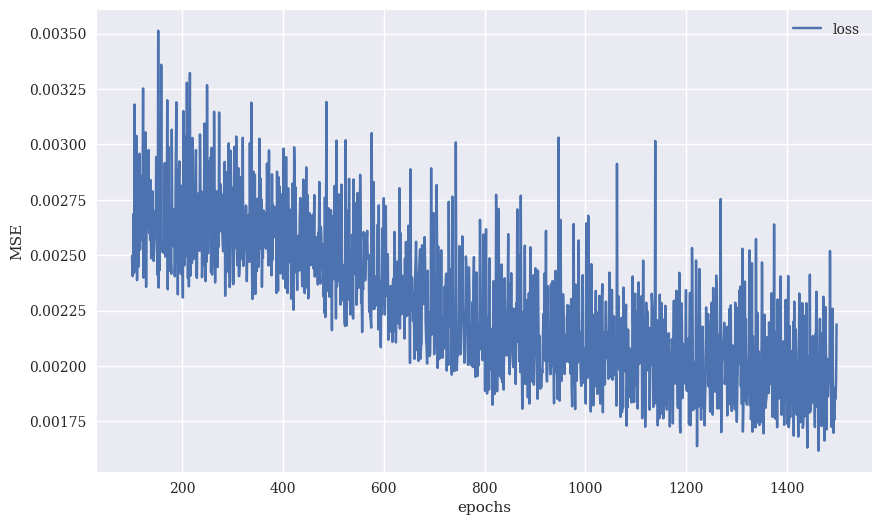

In [30]:
res.iloc[100:].plot(figsize=(10, 6))
plt.ylabel('MSE')
plt.xlabel('epochs');

## Capacity

In [31]:
reg = {}
for d in range(1, 12, 2):
    reg[d] = np.polyfit(f, l, deg=d)
    p = np.polyval(reg[d], f)
    mse = MSE(l, p)
    print(f'{d:2d} | MSE={mse}')

 1 | MSE=0.005322474034260403
 3 | MSE=0.004353110724143182
 5 | MSE=0.0034166422957371025
 7 | MSE=0.0027389501772354
 9 | MSE=0.0014119616263308418
11 | MSE=0.0012651237868752329


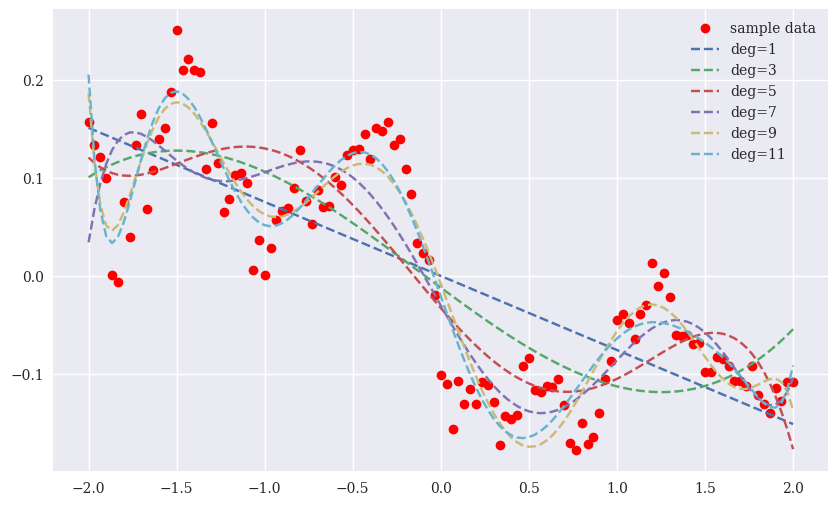

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'ro', label='sample data')
for d in reg:
    p = np.polyval(reg[d], f)
    plt.plot(f, p, '--', label=f'deg={d}')
plt.legend();

In [33]:
def create_dnn_model(hl=1, hu=256):
    ''' Function to create Keras DNN model.
    
    Parameters
    ==========
    hl: int
        number of hidden layers
    hu: int
        number of hidden units (per layer)
    '''
    model = Sequential()
    for _ in range(hl):
        model.add(Dense(hu, activation='relu', input_dim=1))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='rmsprop')
    return model

In [34]:
model = create_dnn_model(3)

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               512       
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 132,353
Trainable params: 132,353
Non-trainable params: 0
_________________________________________________________________


In [36]:
%time model.fit(f, l, epochs=2500, verbose=False)

CPU times: user 16 s, sys: 4.87 s, total: 20.9 s
Wall time: 12.3 s


In [37]:
p = model.predict(f).flatten()

4/4 [==============================] - 0s 784us/step


In [38]:
MSE(l, p)

0.00048376929928665963

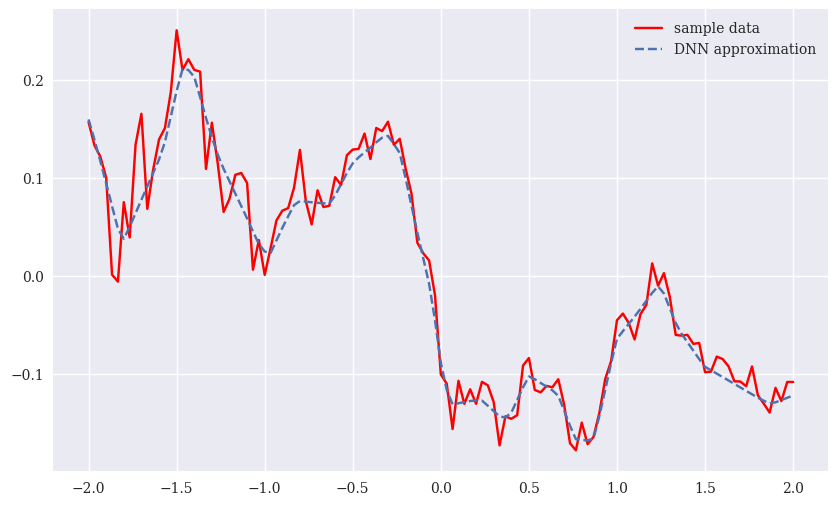

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(f, l, 'r', label='sample data')
plt.plot(f, p, '--', label='DNN approximation')
plt.legend();

## Evaluation

In [40]:
te = int(0.25 * len(f))
va = int(0.25 * len(f))

In [41]:
np.random.seed(100)
ind = np.arange(len(f))
np.random.shuffle(ind)

In [42]:
ind_te = np.sort(ind[:te])
ind_va = np.sort(ind[te:te + va])
ind_tr = np.sort(ind[te + va:])

In [43]:
f_te = f[ind_te]
f_va = f[ind_va]
f_tr = f[ind_tr]

In [44]:
l_te = l[ind_te]
l_va = l[ind_va]
l_tr = l[ind_tr]

In [45]:
reg = {}
mse = {}
for d in range(1, 22, 4):
    reg[d] = np.polyfit(f_tr, l_tr, deg=d)
    p = np.polyval(reg[d], f_tr)
    mse_tr = MSE(l_tr, p)
    p = np.polyval(reg[d], f_va)
    mse_va = MSE(l_va, p)
    mse[d] = (mse_tr, mse_va)
    print(f'{d:2d} | MSE_tr={mse_tr:7.5f} | MSE_va={mse_va:7.5f}')

 1 | MSE_tr=0.00574 | MSE_va=0.00492
 5 | MSE_tr=0.00375 | MSE_va=0.00273
 9 | MSE_tr=0.00132 | MSE_va=0.00243
13 | MSE_tr=0.00094 | MSE_va=0.00183
17 | MSE_tr=0.00060 | MSE_va=0.00153
21 | MSE_tr=0.00046 | MSE_va=0.00837


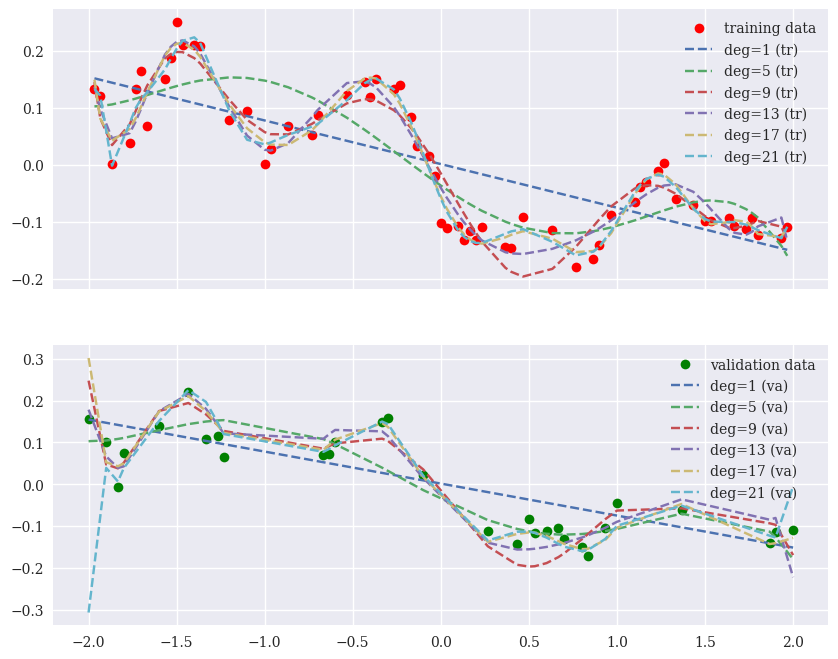

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax[0].plot(f_tr, l_tr, 'ro', label='training data')
ax[1].plot(f_va, l_va, 'go', label='validation data')
for d in reg:
    p = np.polyval(reg[d], f_tr)
    ax[0].plot(f_tr, p, '--', label=f'deg={d} (tr)')
    p = np.polyval(reg[d], f_va)
    plt.plot(f_va, p, '--', label=f'deg={d} (va)')
ax[0].legend()
ax[1].legend();

In [47]:
from keras.callbacks import EarlyStopping

In [48]:
model = create_dnn_model(2, 256)

In [49]:
callbacks = [EarlyStopping(monitor='loss',
                           patience=100,
                          restore_best_weights=True)]

In [50]:
%%time
hist = model.fit(f_tr, l_tr, epochs=3000, verbose=False,
          validation_data=(f_va, l_va),
          callbacks=callbacks)

CPU times: user 17.9 s, sys: 2.58 s, total: 20.5 s
Wall time: 18.3 s


1/1 [==============================] - 0s 8ms/step


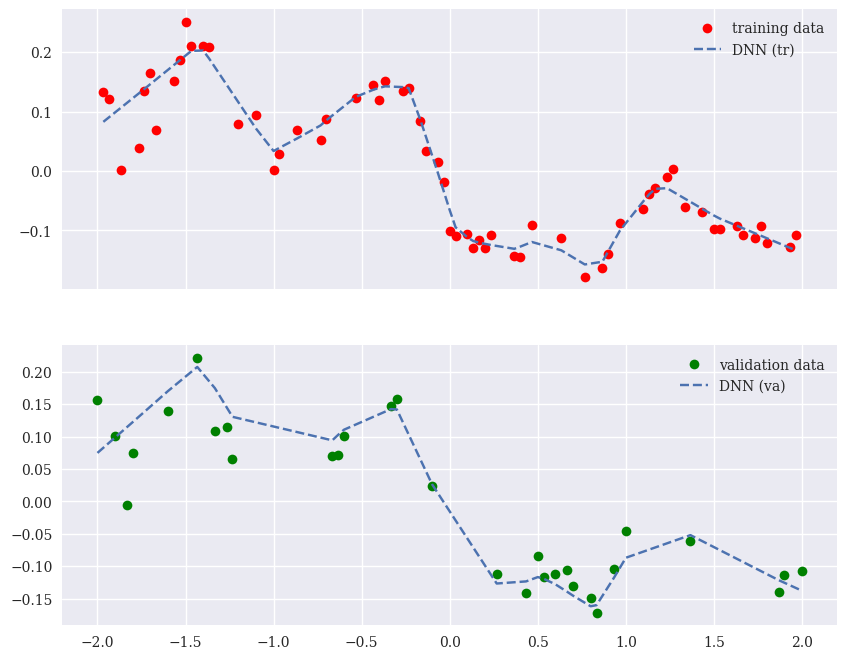

In [51]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
ax[0].plot(f_tr, l_tr, 'ro', label='training data')
p = model.predict(f_tr)
ax[0].plot(f_tr, p, '--', label=f'DNN (tr)')
ax[0].legend()
ax[1].plot(f_va, l_va, 'go', label='validation data')
p = model.predict(f_va)
ax[1].plot(f_va, p, '--', label=f'DNN (va)')
ax[1].legend();

In [52]:
res = pd.DataFrame(hist.history)

In [53]:
res.tail()

,loss,val_loss
1378,0.000996,0.001693
1379,0.000886,0.001449
1380,0.001100,0.001707
1381,0.001111,0.001718
1382,0.000868,0.001455


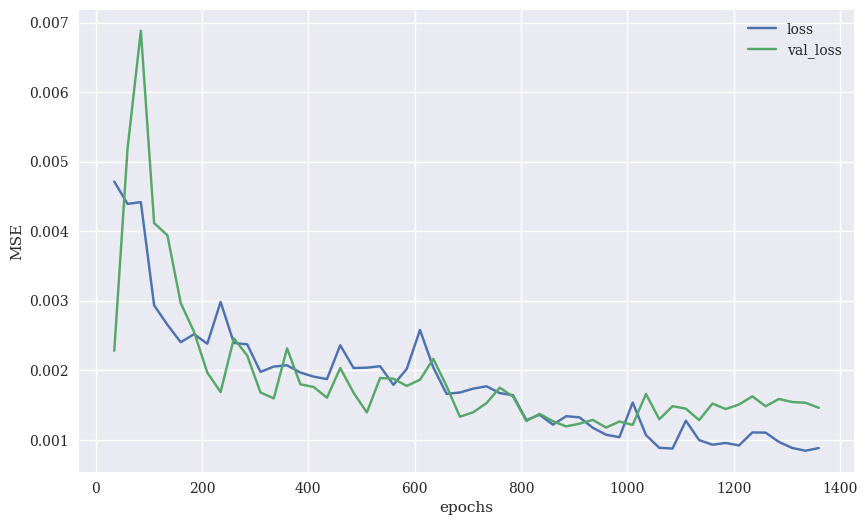

In [54]:
res.iloc[35::25].plot(figsize=(10, 6))
plt.ylabel('MSE')
plt.xlabel('epochs');

In [55]:
p_ols = np.polyval(reg[5], f_te)
p_dnn = model.predict(f_te).flatten()

1/1 [==============================] - 0s 8ms/step


In [56]:
MSE(l_te, p_ols)

0.0038960346771028343

In [57]:
MSE(l_te, p_dnn)

0.0006759646177824616

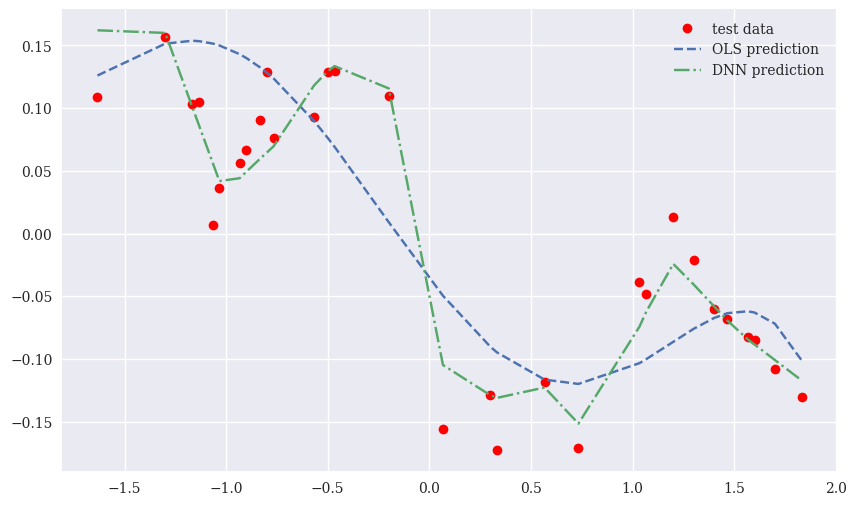

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(f_te, l_te, 'ro', label='test data')
plt.plot(f_te, p_ols, '--', label='OLS prediction')
plt.plot(f_te, p_dnn, '-.', label='DNN prediction');
plt.legend();

## Bias & Variance

In [59]:
f_tr = f[:20:2]
l_tr = l[:20:2]

In [60]:
f_va = f[1:20:2]
l_va = l[1:20:2]

In [61]:
reg_b = np.polyfit(f_tr, l_tr, deg=1)

In [62]:
reg_v = np.polyfit(f_tr, l_tr, deg=9, full=True)[0]

In [63]:
f_ = np.linspace(f_tr.min(), f_va.max(), 75)

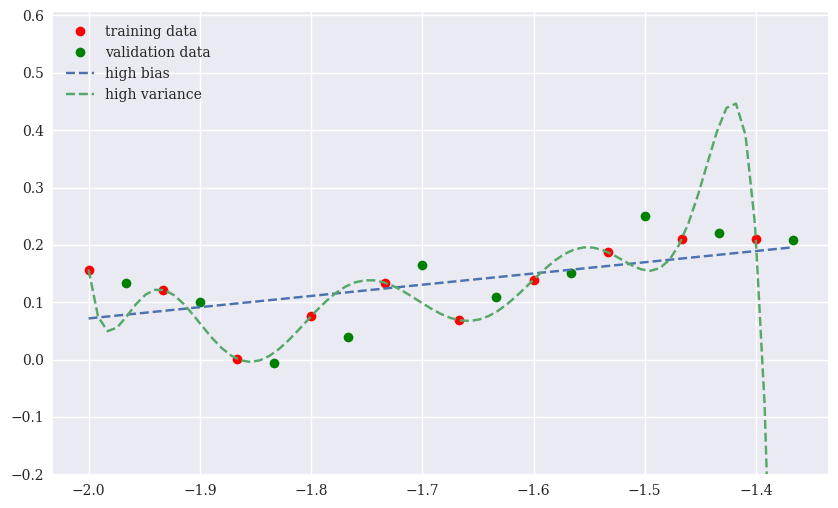

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(f_tr, l_tr, 'ro', label='training data')
plt.plot(f_va, l_va, 'go', label='validation data')
plt.plot(f_, np.polyval(reg_b, f_), '--', label='high bias')
plt.plot(f_, np.polyval(reg_v, f_), '--', label='high variance')
plt.ylim(-0.2)
plt.legend(loc=2);

In [65]:
from sklearn.metrics import r2_score

In [66]:
def evaluate(reg, f, l):
    p = np.polyval(reg, f)
    bias = np.abs(l - p).mean()
    var = p.var()
    msg = f'MSE={MSE(l, p):.4f} | R2={r2_score(l, p):9.4f} | '
    msg += f'bias={bias:.4f} | var={var:.4f}'
    print(msg)

In [67]:
evaluate(reg_b, f_tr, l_tr)

MSE=0.0026 | R2=   0.3484 | bias=0.0423 | var=0.0014


In [68]:
evaluate(reg_b, f_va, l_va)

MSE=0.0032 | R2=   0.4498 | bias=0.0460 | var=0.0014


In [69]:
evaluate(reg_v, f_tr, l_tr)

MSE=0.0000 | R2=   1.0000 | bias=0.0000 | var=0.0040


In [70]:
evaluate(reg_v, f_va, l_va)

MSE=0.8752 | R2=-149.2713 | bias=0.3565 | var=0.7539


## Cross-Validation

In [71]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [72]:
def PolynomialRegression(degree=None, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                        LinearRegression(**kwargs))

In [73]:
np.set_printoptions(suppress=True,
        formatter={'float': lambda x: f'{x:12.2f}'})

In [74]:
print('\nCross-validation scores')
print(74 * '=')
for deg in range(0, 10, 1):
    model = PolynomialRegression(deg)
    cvs = cross_val_score(model, f.reshape(-1, 1), l, cv=5)
    print(f'deg={deg} | ' + str(cvs.round(2)))


Cross-validation scores
deg=0 | [       -6.07        -7.34        -0.09        -6.32        -8.69]
deg=1 | [       -0.28        -1.40         0.16        -1.66        -4.62]
deg=2 | [       -3.48        -2.45         0.19        -1.57       -12.94]
deg=3 | [       -0.00        -1.24         0.32        -0.48       -43.62]
deg=4 | [     -222.81        -2.88         0.37        -0.32      -496.61]
deg=5 | [     -143.67        -5.85         0.49         0.12     -1241.04]
deg=6 | [    -4038.96       -14.71         0.49        -0.33      -317.32]
deg=7 | [    -9937.83       -13.98         0.64         0.22    -18725.61]
deg=8 | [    -3514.36       -11.22        -0.15        -6.29   -298744.18]
deg=9 | [    -7454.15        -0.91         0.15        -0.41    -13580.75]


In [75]:
np.random.seed(100)
tf.random.set_seed(100)
# from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor

In [76]:
model = KerasRegressor(model=create_dnn_model,
                      verbose=False, epochs=1000,
                      hl=1, hu=36)

In [77]:
%time cross_val_score(model, f.reshape(-1, 1), l, cv=5)

CPU times: user 13.5 s, sys: 1.85 s, total: 15.3 s
Wall time: 13.1 s


array([       -4.46,        -5.46,         0.81,         0.12,
             -33.35])

In [78]:
model = KerasRegressor(model=create_dnn_model,
                      verbose=False, epochs=1000,
                      hl=3, hu=256)

In [79]:
%time cross_val_score(model, f.reshape(-1, 1), l, cv=5)

CPU times: user 45.5 s, sys: 8.87 s, total: 54.4 s
Wall time: 40.4 s


array([       -0.40,        -3.22,         0.51,        -0.29,
             -28.13])

<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

<br><br><br><a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:ai@tpq.io">ai@tpq.io</a>